In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import pandas as pd
from net_model import *
from scipy.spatial.distance import cdist
from matplotlib import gridspec
import pickle
import os
import scipy.ndimage as scim
from image_dataset import *

In [2]:
dataset = pickle.load(open('list_dataset.pickle', 'rb'))
# only keep the instances which actually have the images in the folder
dataset = [d for d in dataset if os.path.isfile('../full/' + d[0]) and os.path.isfile('../full/' + d[1])][:300]

image_titles = list(set([(d[0], d[2]) for d in dataset] + [(d[1], d[3]) for d in dataset]))
# divide by 255 to normalize the values
image_list = [scim.imread('../full/' + title) / 255.0 for title, _ in image_titles]
type_list = [type for _, type in image_titles]

# if there are grayscale images, duplicate the channel to make it RGB
image_list = [image if len(image.shape) == 3 else np.repeat(image[:, :, np.newaxis], 3, axis=2)
              for image in image_list]
train = int(0.9 * len(image_list))

train_images = image_list[:train]
train_types = type_list[:train]

test_images = image_list[train:]
test_types = type_list[train:]

In [3]:
#helper function to plot image
def show_image(idxs, images, types, n=None, item_type=None):
    if type(idxs) != np.ndarray:
        idxs = np.array([idxs])
        
    grid_rows = n if n is not None else len(idxs)
    fig = plt.figure(figsize=(3, 3 * grid_rows))
    gs = gridspec.GridSpec(grid_rows, 1)
    
    count = 0
    for i in range(len(idxs)):
        if (item_type is not None and types[idxs[i]] == item_type) or (item_type is None):
            if n is not None:
                if count == n:
                    break
            ax = fig.add_subplot(gs[count, 0])
            ax.imshow(images[idxs[i]])
            ax.axis('off')
            count += 1
    plt.show()

## Create the siamese net feature extraction model

In [4]:
img_placeholder = tf.placeholder(tf.float32, [None, 150, 150, 3], name='img')
net = mynet(img_placeholder, reuse=False)

## Restore from checkpoint and calc the features from all of train data

In [8]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/model.ckpt")
    
    train_feat = sess.run(net, feed_dict={img_placeholder:train_images})

INFO:tensorflow:Restoring parameters from model/model.ckpt


INFO:tensorflow:Restoring parameters from model/model.ckpt


## Searching for similar test images from trainset based on siamese feature

In [179]:
#generate new random test image
idx = np.random.randint(0, len(test_images))
im = image_list[idx]

In [180]:
#run the test image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/model.ckpt")
    search_feat = sess.run(net, feed_dict={img_placeholder:[im]})
    
#calculate the cosine similarity and sort
dist = cdist(train_feat, search_feat, 'cosine')
rank = np.argsort(dist.ravel())

#show the top n similar image from train data
if test_types[idx] == 'top':
    other_type = 'bottom'
elif test_types[idx] == 'bottom':
    other_type = 'top'
elif test_types[idx] == 'full':
    other_type = 'shoes'
elif test_types[idx] == 'acc':
     other_type = 'top'
    
    

INFO:tensorflow:Restoring parameters from model/model.ckpt


INFO:tensorflow:Restoring parameters from model/model.ckpt


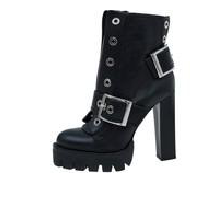

In [181]:
show_image(idx, test_images, test_types)

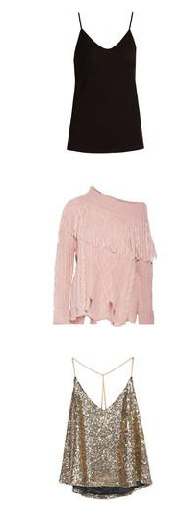

In [182]:
show_image(rank, train_images, train_types, 3, other_type)